# Functions

In [8]:
# Import statements

import h5py
import os
import numpy as np # type: ignore
import pandas as pd # type: ignore
from scipy.interpolate import interp1d

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation


from scipy.signal import savgol_filter


In [9]:

# Import single sleap file for analysis 

# filename = '/Users/ellasay/Google Drive/My Drive/behavior/1.SLEAP/h5/Archive/day1_ctrl_restricted_wheel.mp4.000_day1_ctrl_restricted_wheel.h5'
def import_single_slp(filename):
    with h5py.File(filename, "r") as f:
        dset_names = list(f.keys())
        locations = f["tracks"][:].T
        node_names = [n.decode() for n in f["node_names"][:]]

    print("===filename===")
    print(filename)
    print()

    print("===HDF5 datasets===")
    print(dset_names)
    print()

    print("===locations data shape===")
    print(locations.shape)
    print()

    print("===nodes===")
    for i, name in enumerate(node_names):
        print(f"{i}: {name}")
    print()

# Modified to apply to whole directory of h5 files

def import_h5_dir(directory):
    # Get a list of all .h5 files in the directory
    h5_files = [f for f in os.listdir(directory) if f.endswith('.h5')]

    # Initialize an empty list to store data for the DataFrame
    data = []

    for h5_file in h5_files:
        filename = os.path.join(directory, h5_file)
        
        # Open and process the .h5 file
        with h5py.File(filename, "r") as f:
            # dset_names = list(f.keys())
            locations = f["tracks"][:].T
            node_names = [n.decode() for n in f["node_names"][:]]
            
            # Append the data to the list
            condition = extract_condition(h5_file)
            filename = extract_filename(h5_file)
            data.append({
                'file_name': h5_file,
                'name': filename,
                'location shape': locations.shape,
                'locations': locations,
                'condition': condition

            })
    
    # Create a pandas DataFrame
    df = pd.DataFrame(data)
    
    return df

def extract_condition(filename):
    start = filename.find("_") + 1
    end = filename.find("_0", start)
    if start > 1 and end > -1:
        return filename[start:end]
    return None

def extract_filename(filename):
    start = 0
    end = filename.find(".h5", start)
    return filename[start:end]
  


# Fill in missing values (NaN vavlues due to tracking errors)
def fill_missing(Y, kind="linear"):
    """Fills missing values independently along each dimension after the first."""

    # Store initial shape.
    initial_shape = Y.shape

    # Flatten after first dim.
    Y = Y.reshape((initial_shape[0], -1))

    # Interpolate along each slice.
    for i in range(Y.shape[-1]):
        y = Y[:, i]

        # Build interpolant.
        x = np.flatnonzero(~np.isnan(y))
        f = interp1d(x, y[x], kind=kind, fill_value=np.nan, bounds_error=False)

        # Fill missing
        xq = np.flatnonzero(np.isnan(y))
        y[xq] = f(xq)
        
        # Fill leading or trailing NaNs with the nearest non-NaN values
        mask = np.isnan(y)
        y[mask] = np.interp(np.flatnonzero(mask), np.flatnonzero(~mask), y[~mask])

        # Save slice
        Y[:, i] = y

    # Restore to initial shape.
    Y = Y.reshape(initial_shape)

    return Y

NOSE_INDEX = 0
LEFTEAR_INDEX = 1
RIGHTEAR_INDEX = 2
TORSO_INDEX = 3
TAILBASE = 4

def store_nodes(row):
    nodes = {
        'nose':NOSE_INDEX,
        'leftear': LEFTEAR_INDEX,
        'rightear':RIGHTEAR_INDEX,
        'torso': TORSO_INDEX,
        # 'left_hindpaw': LEFT_HINDPAW,
        # 'right_hindpaw':RIGHT_HINDPAW,
        'tailbase':TAILBASE
    }
    location_dict = {}
    locations = row['locations']

    for node, index in nodes.items():

        x_coords = locations[:,index,0,0]
        y_coords = locations[:,index,1,0]
        location_dict[f'{node}_x'] = x_coords
        location_dict[f'{node}_y'] = y_coords
        # node_loc = locations[:,index,:,:].reshape(-1)
        # location_dict[node] = node_loc

    return pd.Series(location_dict)


# Import dir of .slp files

In [10]:
directory_path = '/Users/ellasay/Google Drive/My Drive/can_project/behavior/v2_model/day2_slp_h5_0914.1'  # Replace with your directory path
df = import_h5_dir(directory_path)
print(df)

                         file_name                          name  \
0   day2_unrestrictedfam_0914.1.h5   day2_unrestrictedfam_0914.1   
1  day2_unrestrictednove_0914.1.h5  day2_unrestrictednove_0914.1   

     location shape                                          locations  \
0  (36606, 5, 2, 1)  [[[[336.06140137], [248.13656616]], [[323.8653...   
1  (36352, 5, 2, 1)  [[[[491.93444824], [347.78814697]], [[481.6706...   

          condition  
0   unrestrictedfam  
1  unrestrictednove  


In [11]:
# organize into table based on condition

# conditions: fixed wheel vs not fixed wheel, novel vs familiar, restricted vs unrestricted


# Fill in NaN values

In [12]:
df['locations'] = df['locations'].apply(fill_missing) # fill_missing is NOT a vectorized function (cannot apply to whole column)

print(df)

                         file_name                          name  \
0   day2_unrestrictedfam_0914.1.h5   day2_unrestrictedfam_0914.1   
1  day2_unrestrictednove_0914.1.h5  day2_unrestrictednove_0914.1   

     location shape                                          locations  \
0  (36606, 5, 2, 1)  [[[[336.06140137], [248.13656616]], [[323.8653...   
1  (36352, 5, 2, 1)  [[[[491.93444824], [347.78814697]], [[481.6706...   

          condition  
0   unrestrictedfam  
1  unrestrictednove  


# store node locations

In [13]:
df = df.join(df.apply(store_nodes,axis=1))
print(df)
print(df.shape)


                         file_name                          name  \
0   day2_unrestrictedfam_0914.1.h5   day2_unrestrictedfam_0914.1   
1  day2_unrestrictednove_0914.1.h5  day2_unrestrictednove_0914.1   

     location shape                                          locations  \
0  (36606, 5, 2, 1)  [[[[336.06140137], [248.13656616]], [[323.8653...   
1  (36352, 5, 2, 1)  [[[[491.93444824], [347.78814697]], [[481.6706...   

          condition                                             nose_x  \
0   unrestrictedfam  [336.0614013671875, 337.9231872558594, 338.080...   
1  unrestrictednove  [491.9344482421875, 491.95166015625, 491.95687...   

                                              nose_y  \
0  [248.13656616210938, 246.15924072265625, 246.2...   
1  [347.78814697265625, 347.8028869628906, 347.81...   

                                           leftear_x  \
0  [323.8653869628906, 324.06378173828125, 324.20...   
1  [481.6706237792969, 297.86297607421875, 297.73...   

           

In [14]:
# add head as a node (average between ears) because ears are the most consistent in video

df['head_x'] = (df['leftear_x'] + df['rightear_x']) / 2
df['head_y'] = (df['leftear_y'] + df['rightear_y']) / 2

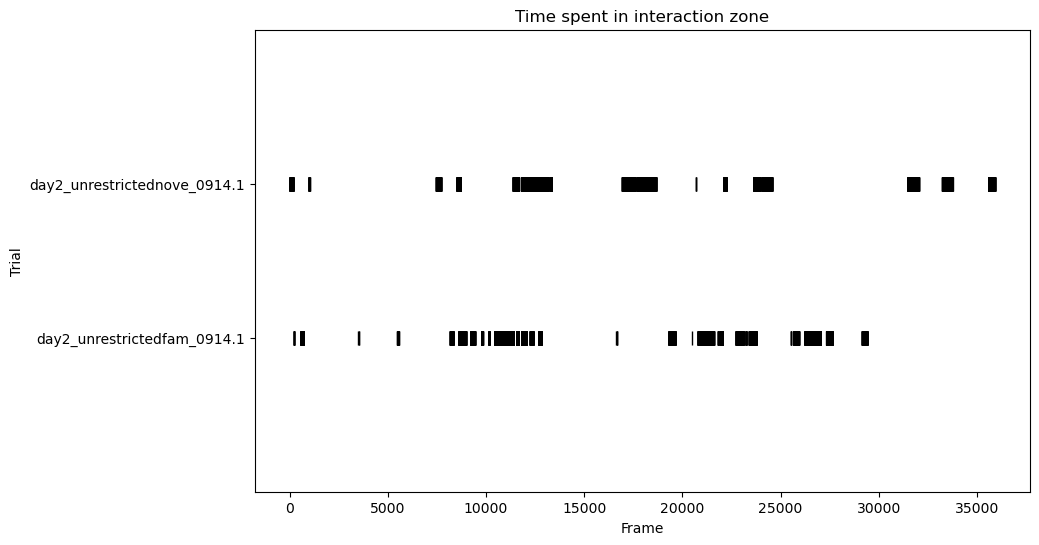

In [15]:
# quantify amount of time spent on the sides vs the middle

# Initialize an empty list to store frame indices for each trial
filtered_frames = []


for i, row in df.iterrows():
    # nose_x = np.array(row['nose_x']).astype(float)
    # nose_y = np.array(row['nose_y']).astype(float)

    head_x = np.array(row['leftear_x']).astype(float)
    head_y = np.array(row['leftear_y']).astype(float)
    
    # interaction zone x = [300,400] y=[200,300]
    # int_zone = (nose_x >= 300) & (nose_x <= 400) & (nose_y >= 200) & (nose_y <= 300)
    int_zone = (head_x >= 300) & (head_x <= 400) & (head_y >= 200) & (head_y <= 250)

    frame_indices = np.where(int_zone)[0]  

    filtered_frames.append(frame_indices)

# plot raster
fig, ax = plt.subplots(figsize=(10, 6))

for i, frames in enumerate(filtered_frames):
    ax.plot(frames, np.ones_like(frames) * i, '|', color='black', markersize=10)  # Raster points for each trial

# Labeling the plot
ax.set_title('Time spent in interaction zone')
ax.set_xlabel('Frame')
ax.set_ylabel('Trial')
ax.set_yticks(range(len(filtered_frames)))
ax.set_yticklabels(df['name'])

ax.set_ylim(-1, len(filtered_frames))

plt.show()





In [16]:
df['filtered_frames'] = filtered_frames
df

,file_name,name,location shape,locations,condition,nose_x,nose_y,leftear_x,leftear_y,rightear_x,rightear_y,torso_x,torso_y,tailbase_x,tailbase_y,head_x,head_y,filtered_frames
0,day2_unrestrictedfam_0914.1.h5,day2_unrestrictedfam_0914.1,"(36606, 5, 2, 1)","[[[[336.06140137], [248.13656616]], [[323.8653...",unrestrictedfam,"[336.0614013671875, 337.9231872558594, 338.080...","[248.13656616210938, 246.15924072265625, 246.2...","[323.8653869628906, 324.06378173828125, 324.20...","[279.8334655761719, 279.7812805175781, 278.186...","[371.78656005859375, 373.7952575683594, 373.82...","[263.947021484375, 265.8720703125, 265.8729553...","[348.04345703125, 348.00897216796875, 347.9830...","[299.77984619140625, 297.91796875, 297.9570922...","[315.8642578125, 315.8865661621094, 315.887573...","[365.90850830078125, 365.8893127441406, 365.88...","[347.8259735107422, 348.9295196533203, 349.013...","[271.89024353027344, 272.82667541503906, 272.0...","[213, 214, 215, 216, 217, 218, 226, 227, 579, ..."
1,day2_unrestrictednove_0914.1.h5,day2_unrestrictednove_0914.1,"(36352, 5, 2, 1)","[[[[491.93444824], [347.78814697]], [[481.6706...",unrestrictednove,"[491.9344482421875, 491.95166015625, 491.95687...","[347.78814697265625, 347.8028869628906, 347.81...","[481.6706237792969, 297.86297607421875, 297.73...","[311.8226623535156, 297.6942138671875, 295.785...","[345.9134216308594, 346.0145568847656, 345.991...","[273.7265625, 269.7740783691406, 264.071533203...","[340.08673095703125, 340.08673095703125, 340.0...","[297.9408264160156, 297.9408264160156, 297.940...","[299.7729187011719, 299.7729187011719, 299.772...","[289.6720886230469, 289.6720886230469, 289.672...","[413.7920227050781, 321.9387664794922, 321.863...","[292.7746124267578, 283.73414611816406, 279.92...","[25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 3..."


In [38]:
percent_interact = []
for i in range(0,len(df)):
    filtered_frames = df["filtered_frames"][i]
    int_frames = len(filtered_frames)
    total_frames = df["location shape"].iloc[i][0]
    temp_percent = (int_frames/total_frames)*100
    percent_interact.append(temp_percent)

df['percent interact'] = percent_interact

df

,file_name,name,location shape,locations,condition,nose_x,nose_y,leftear_x,leftear_y,rightear_x,rightear_y,torso_x,torso_y,tailbase_x,tailbase_y,head_x,head_y,filtered_frames,percent interact
0,day2_unrestrictedfam_0914.1.h5,day2_unrestrictedfam_0914.1,"(36606, 5, 2, 1)","[[[[336.06140137], [248.13656616]], [[323.8653...",unrestrictedfam,"[336.0614013671875, 337.9231872558594, 338.080...","[248.13656616210938, 246.15924072265625, 246.2...","[323.8653869628906, 324.06378173828125, 324.20...","[279.8334655761719, 279.7812805175781, 278.186...","[371.78656005859375, 373.7952575683594, 373.82...","[263.947021484375, 265.8720703125, 265.8729553...","[348.04345703125, 348.00897216796875, 347.9830...","[299.77984619140625, 297.91796875, 297.9570922...","[315.8642578125, 315.8865661621094, 315.887573...","[365.90850830078125, 365.8893127441406, 365.88...","[347.8259735107422, 348.9295196533203, 349.013...","[271.89024353027344, 272.82667541503906, 272.0...","[213, 214, 215, 216, 217, 218, 226, 227, 579, ...",14.055073
1,day2_unrestrictednove_0914.1.h5,day2_unrestrictednove_0914.1,"(36352, 5, 2, 1)","[[[[491.93444824], [347.78814697]], [[481.6706...",unrestrictednove,"[491.9344482421875, 491.95166015625, 491.95687...","[347.78814697265625, 347.8028869628906, 347.81...","[481.6706237792969, 297.86297607421875, 297.73...","[311.8226623535156, 297.6942138671875, 295.785...","[345.9134216308594, 346.0145568847656, 345.991...","[273.7265625, 269.7740783691406, 264.071533203...","[340.08673095703125, 340.08673095703125, 340.0...","[297.9408264160156, 297.9408264160156, 297.940...","[299.7729187011719, 299.7729187011719, 299.772...","[289.6720886230469, 289.6720886230469, 289.672...","[413.7920227050781, 321.9387664794922, 321.863...","[292.7746124267578, 283.73414611816406, 279.92...","[25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 3...",14.255062


# Analysis

In [26]:
sns.set('notebook', 'ticks', font_scale=1.2)
mpl.rcParams['figure.figsize'] = [15,6]

In [27]:
df

,file_name,name,location shape,locations,condition,nose_x,nose_y,leftear_x,leftear_y,rightear_x,rightear_y,torso_x,torso_y,tailbase_x,tailbase_y,head_x,head_y,filtered_frames
0,day2_unrestrictedfam_0914.1.h5,day2_unrestrictedfam_0914.1,"(36606, 5, 2, 1)","[[[[336.06140137], [248.13656616]], [[323.8653...",unrestrictedfam,"[336.0614013671875, 337.9231872558594, 338.080...","[248.13656616210938, 246.15924072265625, 246.2...","[323.8653869628906, 324.06378173828125, 324.20...","[279.8334655761719, 279.7812805175781, 278.186...","[371.78656005859375, 373.7952575683594, 373.82...","[263.947021484375, 265.8720703125, 265.8729553...","[348.04345703125, 348.00897216796875, 347.9830...","[299.77984619140625, 297.91796875, 297.9570922...","[315.8642578125, 315.8865661621094, 315.887573...","[365.90850830078125, 365.8893127441406, 365.88...","[347.8259735107422, 348.9295196533203, 349.013...","[271.89024353027344, 272.82667541503906, 272.0...","[213, 214, 215, 216, 217, 218, 226, 227, 579, ..."
1,day2_unrestrictednove_0914.1.h5,day2_unrestrictednove_0914.1,"(36352, 5, 2, 1)","[[[[491.93444824], [347.78814697]], [[481.6706...",unrestrictednove,"[491.9344482421875, 491.95166015625, 491.95687...","[347.78814697265625, 347.8028869628906, 347.81...","[481.6706237792969, 297.86297607421875, 297.73...","[311.8226623535156, 297.6942138671875, 295.785...","[345.9134216308594, 346.0145568847656, 345.991...","[273.7265625, 269.7740783691406, 264.071533203...","[340.08673095703125, 340.08673095703125, 340.0...","[297.9408264160156, 297.9408264160156, 297.940...","[299.7729187011719, 299.7729187011719, 299.772...","[289.6720886230469, 289.6720886230469, 289.672...","[413.7920227050781, 321.9387664794922, 321.863...","[292.7746124267578, 283.73414611816406, 279.92...","[25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 3..."


Text(0.5, 1.0, 'Ear tracks')

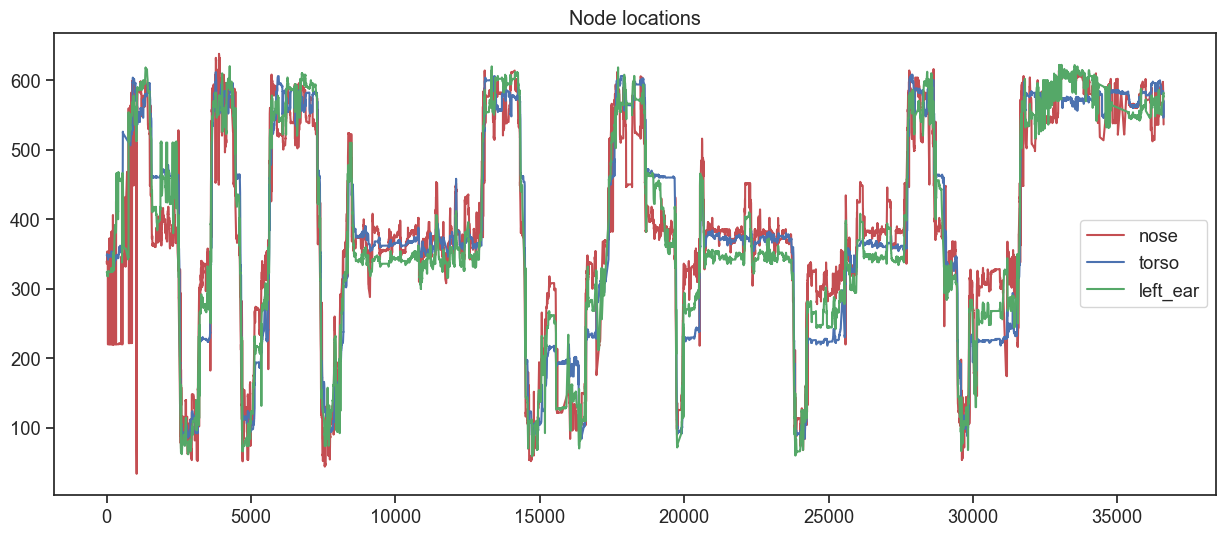

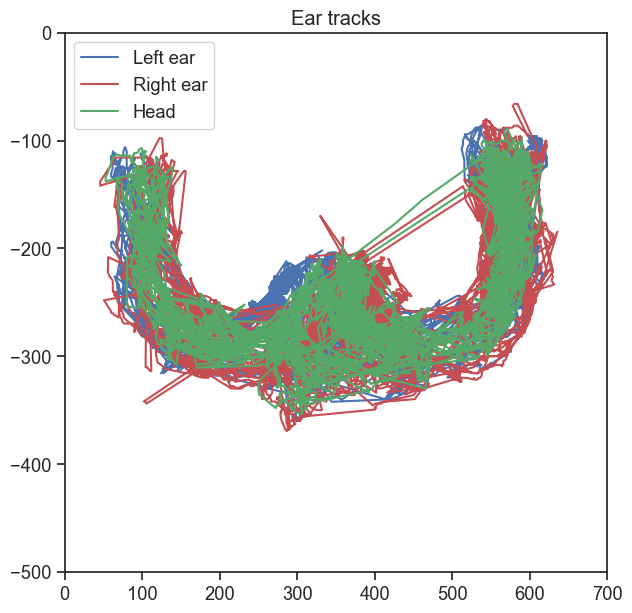

In [29]:
i = 0
plt.figure()
plt.plot(df['nose_x'].iloc[i], 'r',label='nose')
# plt.plot(-1*nose_loc[:,1,0], 'r')
plt.plot(df['torso_x'].iloc[i], 'b',label='torso')
plt.plot(df['leftear_x'].iloc[i], 'g',label='left_ear')
# plt.plot(rightear_loc[:,0,0], 'y',label='right_ear')

plt.legend(loc="center right")
plt.title('Node locations')


plt.figure(figsize=(7,7))
# plt.plot(df['nose_x'][i],-1*df['nose_y'][i], 'b',label='day1_ctrl')
plt.plot(df['leftear_x'][i],-1*df['leftear_y'][i], 'b',label='Left ear')
plt.plot(df['rightear_x'][i],-1*df['rightear_y'][i], 'r',label='Right ear')
plt.plot(df['head_x'][i],-1*df['head_y'][i], 'g',label='Head')


plt.legend()

plt.xlim(0,700)
# plt.xticks([])

plt.ylim(-500,0)
#plt.yticks([])
plt.title('Ear tracks')

# color 250-450 as "interaction phase"


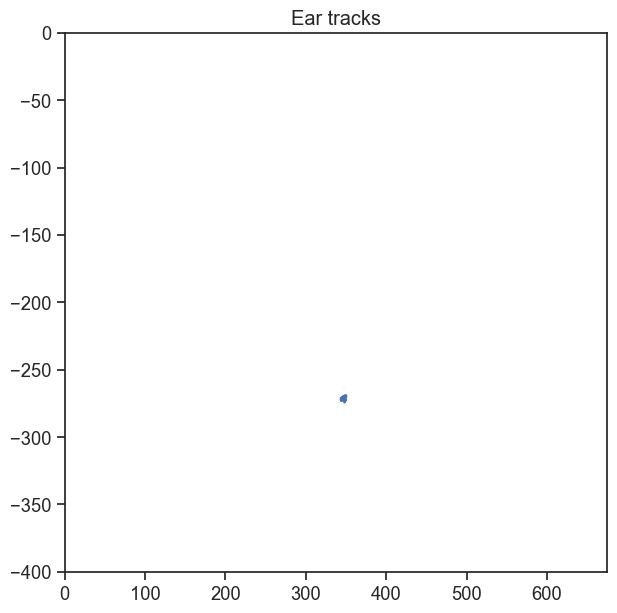

In [30]:
import matplotlib.animation as animation  
# generate video 



# creating a blank window 
# for the animation  
fig = plt.figure(figsize=(7,7))  
# plt.figure(figsize=(7,7))
axis = plt.axes(xlim =(0, 675), 
                ylim =(-400, 0)) 
line, = axis.plot([], [], lw = 2)  


plt.title('Ear tracks')
   
# what will our line dataset 
# contain? 
def init():  
    line.set_data([], [])  
    return line,  
   
# initializing empty values 
# for x and y co-ordinates 
xdata, ydata = [], []  
   
# animation function  
def animate(i):  
    # t is a parameter which varies 
    # with the frame number 

    t = 0  
       
    # x, y values to be plotted  
    x = df['head_x'][t][i]
    y = -1*df['head_y'][t][i]
       
    # appending values to the previously  
    # empty x and y data holders  
    xdata.append(x)  
    ydata.append(y)  
    line.set_data(xdata, ydata)  

    # axis.set_xlim =([0, 700])
    # axis.set_ylim =([-500, 0])
      
    return line, 
   
# calling the animation function      
anim = animation.FuncAnimation(fig, animate, init_func = init,  
                               frames = 50, interval = 1, blit = True)  
   
# saves the animation in our desktop 
anim.save('test.mp4', writer = 'ffmpeg', fps = 120) 
# plt.show()

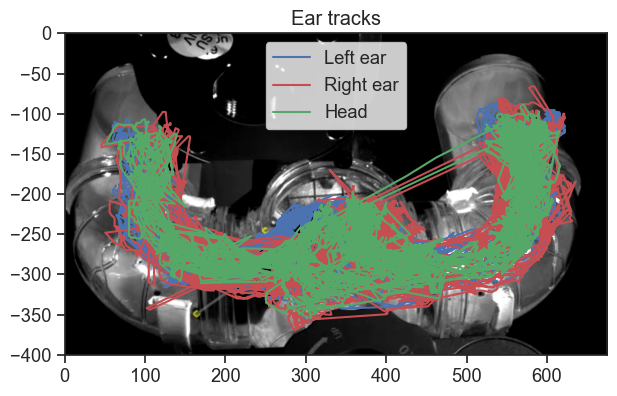

In [31]:
import matplotlib.pyplot as plt

# Load the image
img = plt.imread("day1_restrictwheel_0914.1.png")

# Set up the figure and axes with the specified size
fig, ax = plt.subplots(figsize=(7, 7))

# Display the image in the background
ax.imshow(img, extent=[0, 675, -400, 0])

# Plot the ear and head tracks
i = 0  # Example index; modify as needed for specific trials or data points
ax.plot(df['leftear_x'][i], -1 * df['leftear_y'][i], 'b', label='Left ear')
ax.plot(df['rightear_x'][i], -1 * df['rightear_y'][i], 'r', label='Right ear')
ax.plot(df['head_x'][i], -1 * df['head_y'][i], 'g', label='Head')

# Set limits to match the image size
ax.set_xlim(0, 675)
ax.set_ylim(-400, 0)

# Add legend and title
ax.legend()
ax.set_title('Ear tracks')

plt.show()


In [35]:

def smooth_diff(node_loc, win=25, poly=3):
    """
    node_loc is a [frames, 2] array
    
    win defines the window to smooth over
    
    poly defines the order of the polynomial
    to fit with
    
    """
    node_loc_vel = np.zeros_like(node_loc)
    
    for c in range(node_loc.shape[-1]):
        node_loc_vel[:, c] = savgol_filter(node_loc[:, c], win, poly, deriv=1)
    
    node_vel = np.linalg.norm(node_loc_vel,axis=1)

    return node_vel

In [40]:
nose_loc = df['nose_x'].iloc[i],df['nose_y'].iloc[i]
nose_vel = smooth_diff(nose_loc)
# torso_vel = smooth_diff(torso_loc[:,:,0])


AttributeError: 'tuple' object has no attribute 'shape'

Text(0.5, 1.0, 'Velocity')

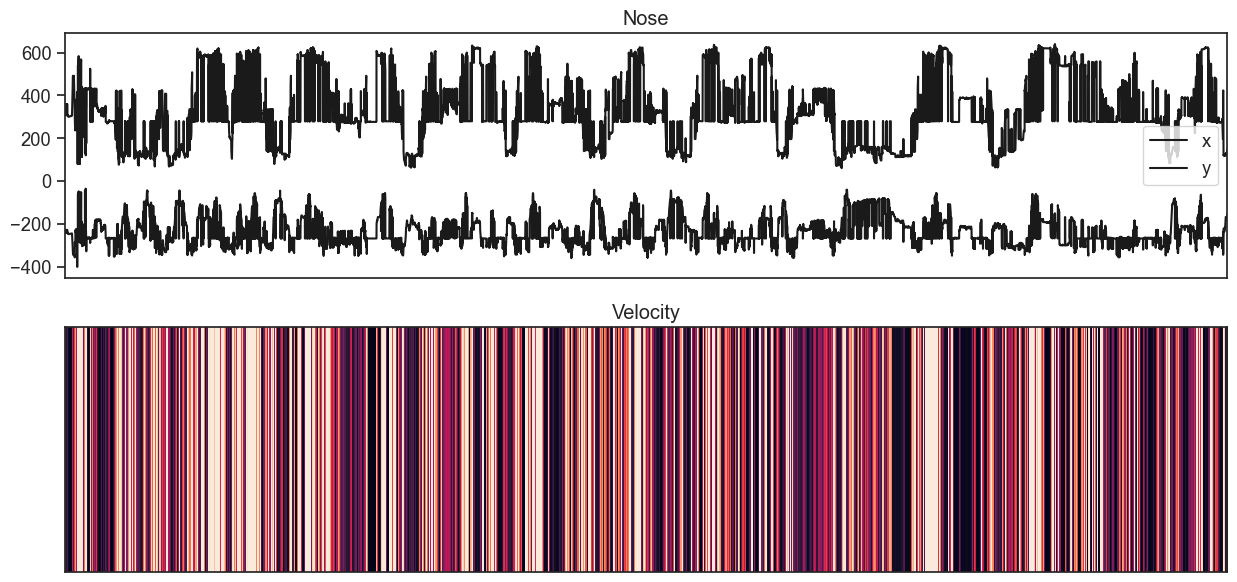

In [65]:
fig = plt.figure(figsize=(15,7))
ax1 = fig.add_subplot(211)
ax1.plot(nose_loc[:, 0, 0], 'k', label='x')
ax1.plot(-1*nose_loc[:, 1, 0], 'k', label='y')
ax1.legend()
ax1.set_xticks([])
ax1.set_title('Nose')

ax2 = fig.add_subplot(212, sharex=ax1)
ax2.imshow(nose_vel[:,np.newaxis].T, aspect='auto', vmin=0, vmax=10)
ax2.set_yticks([])
ax2.set_title('Velocity')

Text(0.5, 1.0, 'Nose tracks colored by magnitude of animal speed')

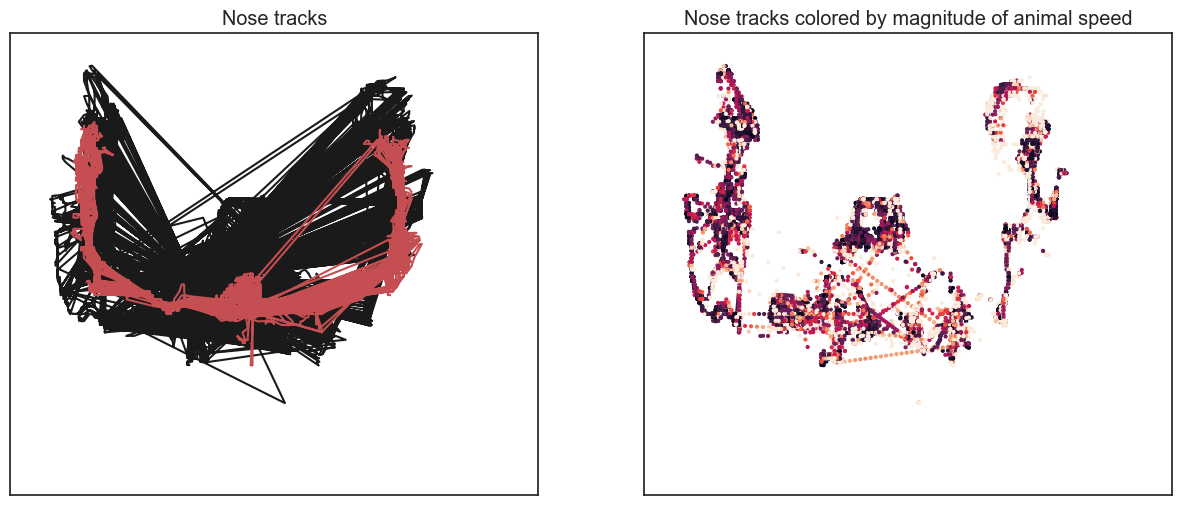

In [66]:
fig = plt.figure(figsize=(15,6))
ax1 = fig.add_subplot(121)
ax1.plot(nose_loc[:, 0, 0], -1*nose_loc[:, 1, 0], 'k')
ax1.plot(torso_loc[:, 0, 0], -1*torso_loc[:, 1, 0], 'r')
ax1.set_xlim(0,800)
ax1.set_xticks([])
ax1.set_ylim(-500,0)
ax1.set_yticks([])
ax1.set_title('Nose tracks')

kp = nose_vel  
vmin = 0
vmax = 10

ax2 = fig.add_subplot(122)
ax2.scatter(nose_loc[:,0,0], -1*nose_loc[:,1,0], c=kp, s=4, vmin=vmin, vmax=vmax)

ax2.set_xlim(0,800)
ax2.set_xticks([])
ax2.set_ylim(-500,0)
ax2.set_yticks([])
ax2.set_title('Nose tracks colored by magnitude of animal speed')


# lp = torso_vel
# ax3 = fig.add_subplot(120)
# ax3.scatter(torso_loc[:,0,0], -1*torso_loc[:,1,0], c=lp, s=4, vmin=vmin, vmax=vmax)

# ax3.set_xlim(0,800)
# ax3.set_xticks([])
# ax3.set_ylim(-500,0)
# ax3.set_yticks([])
# ax3.set_title('Torso tracks colored by magnitude of animal speed')

In [37]:
def instance_node_velocities(instance_idx):
    node_locations = locations[:, :, :, instance_idx]
    node_velocities = np.zeros((frame_count, node_count))

    for n in range(0, node_count):
        node_velocities[:, n] = smooth_diff(node_locations[:, n, :])
    
    return node_velocities

In [38]:
def plot_instance_node_velocities(instance_idx, node_velocities):
    plt.figure(figsize=(20,8))
    plt.imshow(node_velocities.T, aspect='auto', vmin=0, vmax=20, interpolation="nearest")
    plt.xlabel('frames')
    plt.ylabel('nodes')
    plt.yticks(np.arange(node_count), node_names, rotation=20);
    plt.title(f'Animal {instance_idx} node velocities')

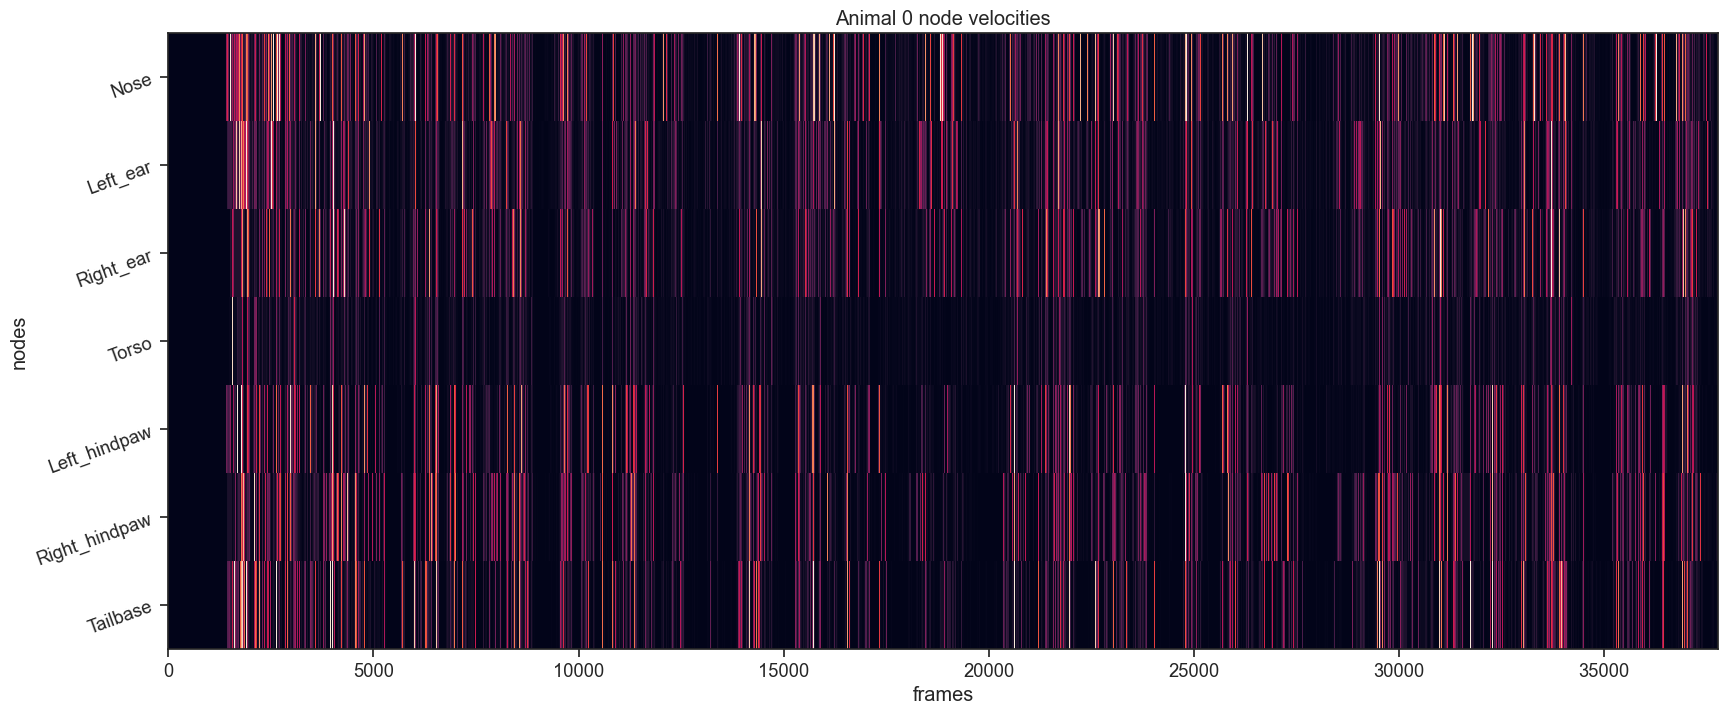

In [39]:
animal_ID = 0
node_velocities = instance_node_velocities(animal_ID)
plot_instance_node_velocities(animal_ID, node_velocities)